### Seminar 8: Intro to graph neural networks (GNNs)

Goals/Agenda

- Construct periodic graphs
- Reproduce [CGCNN](https://arxiv.org/abs/1710.10324) model  from scratch

- Train regression model for prediction of formation energy of crystal structures

### First of all enable GPU acceleration
Go Runtime->Change runtime type->T4 GPU

In [1]:
# install torch-geometric, torch-scatter, etc
# https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7

import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 43.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 71.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.0 MB/s eta 0:00:00


In [2]:
torch.cuda.is_available()

True

In [3]:
!pip install vesin
!pip install ase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.8 MB/s eta 0:00:00


## Prepare data

We will work with a sample of the MPF2021 [dataset](https://figshare.com/articles/dataset/MPF_2021_2_8/19470599).

In [4]:
# download files
!mkdir data
!wget -O./data/MPF.2021.2.8.cleaned.sample.xyz.zip https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar08/MPF.2021.2.8.cleaned.sample.xyz.zip

--2025-09-28 16:05:34--  https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar08/MPF.2021.2.8.cleaned.sample.xyz.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7523054 (7.2M) [application/zip]
Saving to: ‘./data/MPF.2021.2.8.cleaned.sample.xyz.zip’

./data/MPF.2021.2.8 100%[===================>]   7.17M  --.-KB/s    in 0.07s   

2025-09-28 16:05:34 (99.5 MB/s) - ‘./data/MPF.2021.2.8.cleaned.sample.xyz.zip’ saved [7523054/7523054]



In [5]:
!unzip data/MPF.2021.2.8.cleaned.sample.xyz.zip -d data/

Archive:  data/MPF.2021.2.8.cleaned.sample.xyz.zip
  inflating: data/MPF.2021.2.8.cleaned.sample.xyz  
  inflating: data/__MACOSX/._MPF.2021.2.8.cleaned.sample.xyz  


In [6]:
from ase.io import read

atoms_list = read('data/MPF.2021.2.8.cleaned.sample.xyz', index = ':')

In [7]:
atoms_list[-1].info

{'energy_per_atom': np.float64(-6.5307305935),
 'forces': array([[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00185993,  0.00445237,  0.00483463],
        [ 0.00185993, -0.00445237, -0.00483463],
        [ 0.00185993, -0.00445237, -0.00483463],
        [-0.00185993,  0.00445237,  0.00483463],
        [-0.00177286,  0.00064558,  0.00460832],
        [ 0.00177286, -0.00064558, -0.00460832],
        [-0.00049551,  0.00478455,  0.00128802],
        [ 0.00049551, -0.00478455, -0.00128802],
        [ 0.00177444,  0.00804087, -0.00461243],
        [-0.00258777, -0.0060939 ,  0.00672656],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00177444, -0.00804087,  0.00461243],
        [ 0.00258777,  0.0060939 , -0.00672656],
        [ 0.00215947, -0.00353071, -0.00561325],
        [-0.00215947,  0.00353071,  0.00561325],
        [-0.00157775,  0.00541562,  0.00410116],
        [ 0.

<BarContainer object of 87 artists>

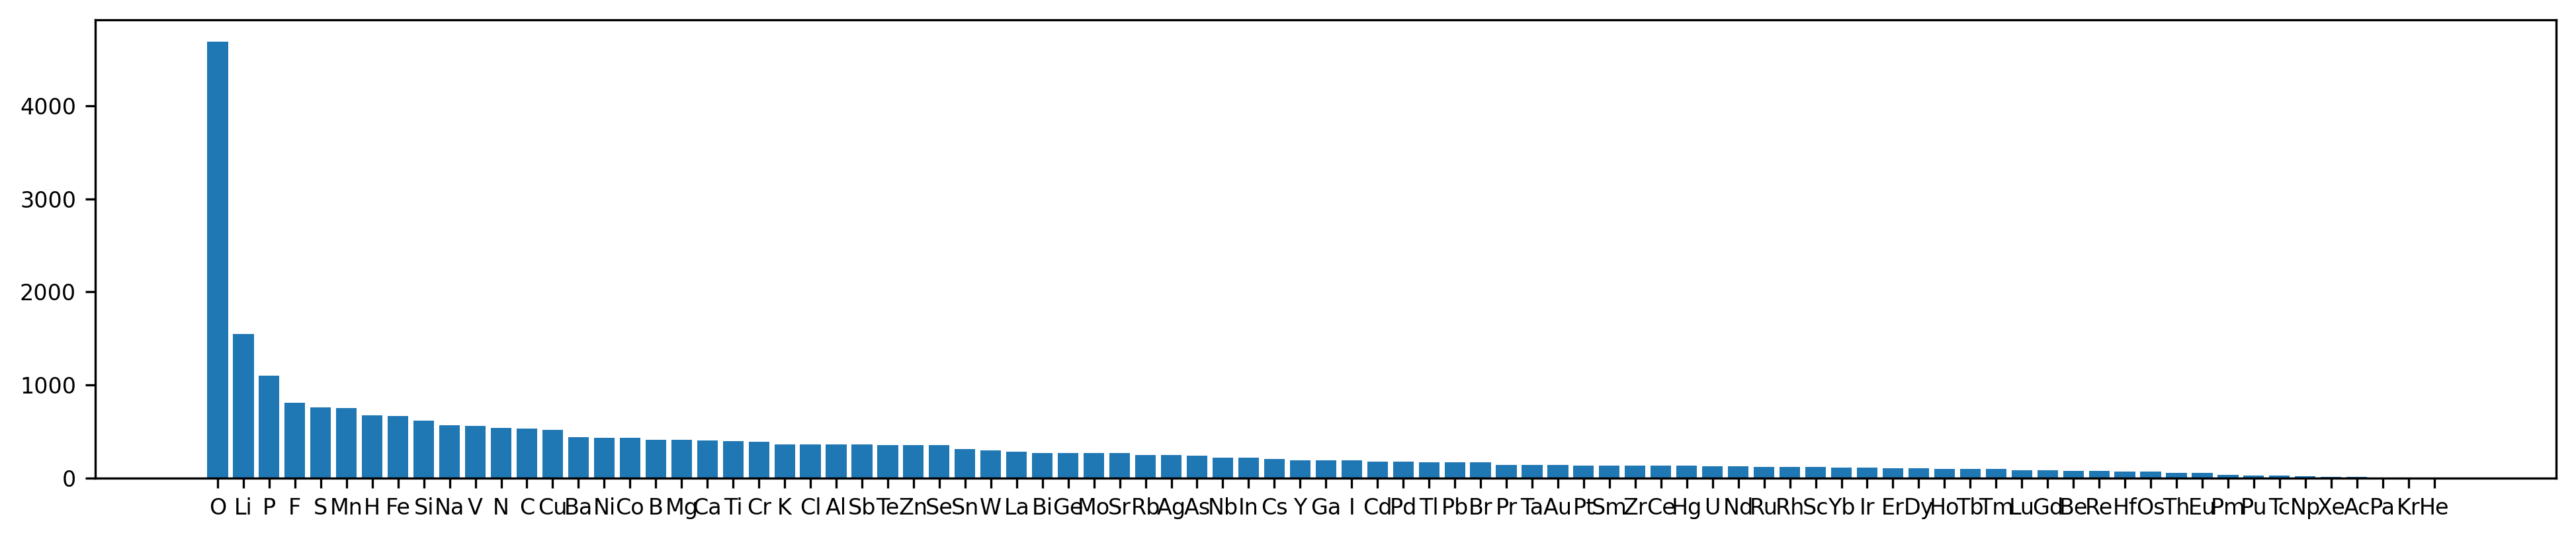

In [8]:
# brief overview of the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

elements = {}
numbers = []

for atoms in atoms_list:
    for s in np.unique(atoms.symbols):
        if s not in list(elements.keys()):
            elements.update({s: 1})
        else:
            elements[s] += 1

    for n in np.unique(atoms.numbers):
        if n not in numbers:
            numbers.append(n)



df = pd.DataFrame(data = elements, index = ['count']).T
df = df.sort_values(by = 'count', ascending=False).reset_index()

plt.rcParams.update({'font.size':8})
plt.figure(dpi = 300, figsize = (16, 3))
plt.bar(df['index'].values, df['count'])


In [9]:
max(numbers) # the maximum number is 94

np.int64(94)

In [10]:
len(elements.keys()) # there are 87 different elements

87

Text(0.5, 0, 'Count, eV/atom')

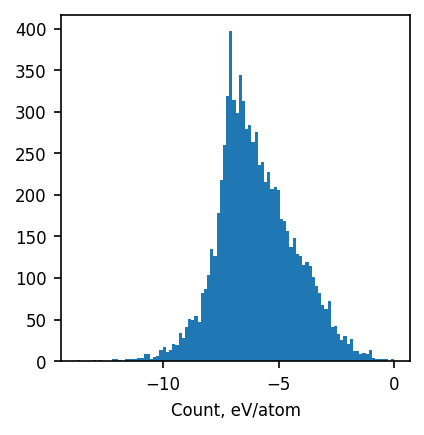

In [11]:
energies = [atoms.info['energy_per_atom'] for atoms in atoms_list]

plt.figure(dpi = 150, figsize = (3, 3))
_ = plt.hist(energies, bins = 100)
plt.xlabel('Energy, eV/atom')
plt.xlabel('Count, eV/atom')

In [12]:
import torch
import numpy as np
from vesin import NeighborList
from torch_geometric.data import Data
from ase.io import read

# this function:
# 1. collects nearest neighbors
# 2. prepares torch-geometrc Data object with required attributes
#    (edge_index, edge_length, atomic_numbers, etc)


def atoms2data(atoms,
               r_cut=None,
               energy_key=None,
               n_max_neighbors=None,
               node_featurizer=None,
               edge_featurizer=None,
               ):

    # we use vesin library to collect neighbors of each atom
    calculator = NeighborList(cutoff=r_cut, full_list=True)
    i, j, ij_length, offset, ij_vector = calculator.compute(
        points=atoms.positions,
        box=atoms.cell,
        periodic=True in atoms.pbc,
        quantities="ijdSD" # source, target, edge length, offset vector, and edge vector
    )

    # truncate list of neighbors if needed
    # CGCNN original paper uses 12 neighbors
    if n_max_neighbors is not None:
        filtered_indices = []
        for atom_idx in np.unique(i):
            mask = (i == atom_idx)
            indices = np.where(mask)[0]
            sorted_indices = indices[np.argsort(ij_length[mask])]
            filtered_indices.extend(sorted_indices[:n_max_neighbors])
        i = i[filtered_indices]
        j = j[filtered_indices]
        ij_length = ij_length[filtered_indices]
        offset = offset[filtered_indices]
        ij_vector = ij_vector[filtered_indices]

    # convert to torch objects and prepare a torch_geometric Data object
    ij = torch.stack([torch.LongTensor(i), torch.LongTensor(j)])
    data = Data(
        edge_index=ij,
        edge_vector=torch.tensor(ij_vector, dtype=torch.float32),
        edge_length=torch.tensor(ij_length, dtype=torch.float32),
        positions=torch.tensor(atoms.positions, dtype=torch.float32),
        offset=torch.tensor(offset, dtype=torch.float32),
        numbers=torch.LongTensor(atoms.get_atomic_numbers()),
        energy=None if energy_key is None else torch.tensor(atoms.info[energy_key], dtype=torch.float32),
    )

    # optional attributes to compute
    if node_featurizer is not None:
        data.node_attr = node_featurizer(data)
    if edge_featurizer is not None:
        data.edge_attr = edge_featurizer(data)
    return data

In [13]:
from sklearn.model_selection import train_test_split

atoms_train, atoms_test = train_test_split(atoms_list, test_size = 0.1)
atoms_train, atoms_val = train_test_split(atoms_train, test_size = 0.1)

In [14]:
r_cut = 6.0
energy_key='energy_per_atom'
n_max_neighbors=12

# create train/val/test data
train_data = [atoms2data(atoms, r_cut=r_cut, n_max_neighbors=n_max_neighbors, energy_key=energy_key) for atoms in atoms_train]
val_data = [atoms2data(atoms, r_cut=r_cut, n_max_neighbors=n_max_neighbors, energy_key=energy_key) for atoms in atoms_val]
test_data = [atoms2data(atoms, r_cut=r_cut, n_max_neighbors=n_max_neighbors, energy_key=energy_key) for atoms in atoms_test]

In [15]:
train_data[0]

Data(edge_index=[2, 288], edge_vector=[288, 3], edge_length=[288], positions=[24, 3], offset=[288, 3], numbers=[24], energy=-6.835033893585205)

In [16]:
len(train_data), len(val_data), len(test_data), len(atoms_list)

(6828, 759, 843, 8430)

# Build a model

CGCNN model uses a graph convolution operation where node features are updated via message-passing by aggregating information from neighboring nodes and associated edge features.

The steps below are the common mechanism of a message passing:

- Message computation: Create messages from neighbors

- Aggregation: Combine messages from all neighbors

- Update: Update node features using aggregated messages


**Message is given by the following formula:**

$$z_{(i,j)k}^{(t)} = v_i^{(t)} \oplus v_j^{(t)} \oplus u_{(i,j)k}$$

Where:

- $v$ is node attributes

- $u$ is edge attributes

- $\oplus$ represents concatenation operation


**Node update is given by the following formula**:

$$v_i^{(t+1)} = v_i^{(t)} + \sum_{j,k} \sigma \left( z_{(i,j)k}^{(t)} W_f^{(t)} + b_f^{(t)} \right) \circ g \left( z_{(i,j)k}^{(t)} W_s^{(t)} + b_s^{(t)} \right)$$

Where:



- $\sigma$ is an activation function

- $g$ is another activation function

- $\circ$ denotes element-wise multiplication

- The superscript $(t)$ indicates the number of a layer

- Subscripts $i,j,k$ index nodes/edges in a graph structure

### Node attributes

In the original paper, CGCNN uses some element-based features as node attributes (electronegativity, etc). We will use one-hot encoding as implemented in `torch.nn.Embedding` layer. Will see it later.


In [17]:
import torch.nn.functional as F

one_hot = F.one_hot(train_data[0].numbers, num_classes=max(numbers) + 1)
one_hot.shape # there are 20 atoms and each has 1 x 94 feature


torch.Size([24, 95])

### Edge attributes

Each edge is converted into a feature of a fixed length using the gaussian filter as shown below.

In [18]:
import torch.nn as nn

class GaussianFilter(nn.Module):

    def __init__(self, r_min=1.0, r_max=6.0, num_edge_features=64):

        super(GaussianFilter, self).__init__()
        self.r_min = r_min
        self.r_max = r_max
        self.num_edge_features = num_edge_features
        _filter = torch.linspace(r_min, r_max, num_edge_features)
        step = (r_max - r_min) / num_edge_features
        self.register_buffer("_filter", _filter)
        self.register_buffer("step", torch.tensor(step))

    def forward(self, edge_length):

        if not isinstance(edge_length, torch.Tensor):
            edge_length = torch.tensor(edge_length, dtype=torch.float32)
        edge_length = edge_length.to(self._filter.device)
        diff = edge_length[:, None] - self._filter
        out = torch.exp(-0.5 * torch.square(diff / self.step))
        return out


featurizer = GaussianFilter()

# there are 240 edges, each has a 1 x 64 feature
featurizer(train_data[0].edge_length).shape


torch.Size([288, 64])

### Graph convolution

In [19]:
import torch
from torch_scatter import scatter, scatter_add


class GraphConvLayer(nn.Module):

    def __init__(self, node_fea_len, edge_fea_len):

        """
        Simple convolution layer from CGCNN paper

        Params
        ------

        node_fea_len: int
            length of the node feature
        edge_fea_len: int
            length of the edge feature

        """
        super(GraphConvLayer, self).__init__()

        # size of input feature z is 2 * node_fea_len + edge_fea_len
        self.lin_f = nn.Linear(2 * node_fea_len + edge_fea_len, node_fea_len)
        self.lin_s = nn.Linear(2 * node_fea_len + edge_fea_len, node_fea_len)

        # normalization of the node features
        self.norm = nn.BatchNorm1d(node_fea_len)


    def forward(self, node_attrs, edge_index, edge_attrs):

        # soure and target nodes of the edge
        source, target = edge_index

        # features of the source nodes
        x_i = node_attrs[source]

        # features of the target nodes
        x_j = node_attrs[target]

        # concatenation of the source, target, and edge features
        z = torch.cat([x_i, x_j, edge_attrs], dim=-1).float()

        # convolution
        gate = torch.sigmoid(self.lin_f(z))
        message = nn.functional.leaky_relu(self.lin_s(z), negative_slope=0.01)
        z = gate * message

        # aggregation of the messages -> sum up all the messages comming to the souce node
        # see image below to get an idea of scatter_add operation
        total_message = scatter_add(z, source, dim = 0)

        # node features update
        out = node_attrs + self.norm(total_message)

        return out


## An illustration of how scatter_add works

<img src="https://raw.githubusercontent.com/rusty1s/pytorch_scatter/master/docs/source/_figures/add.svg?sanitize=true"
     alt="Scatter Add Operation"
     width="500"
     style="display: block; margin: 0 auto;">

## Full model

In [20]:
class ConvGNN(nn.Module):
    def __init__(self, orig_node_fea_len, edge_fea_len, node_fea_len=64, h_fea_len=128, reduce='mean'):
        super(ConvGNN, self).__init__()

        self.reduce = reduce
        self.embedding = nn.Embedding(orig_node_fea_len, node_fea_len)
        self.filter = GaussianFilter(num_edge_features=edge_fea_len)

        self.norm = nn.BatchNorm1d(node_fea_len)
        self.conv1 = GraphConvLayer(node_fea_len, edge_fea_len)
        self.conv2 = GraphConvLayer(node_fea_len, edge_fea_len)
        self.conv3 = GraphConvLayer(node_fea_len, edge_fea_len)

        self.linear = nn.Linear(node_fea_len, h_fea_len)
        self.linear2 = nn.Linear(h_fea_len, 1)

        # you can add dropout for regularization

    def forward(self, batch):

        # embedding -> norm ->conv->conv->conv->linear->activation->linear->scatter

        atomic_embeddings = self.embedding(batch['numbers'])
        atomic_embeddings = self.norm(atomic_embeddings)

        batch['edge_attrs'] = self.filter(batch['edge_length'])

        # message-passing
        atomic_embeddings = self.conv1(atomic_embeddings, batch['edge_index'], batch['edge_attrs'])
        atomic_embeddings = self.conv2(atomic_embeddings, batch['edge_index'], batch['edge_attrs'])
        atomic_embeddings = self.conv3(atomic_embeddings, batch['edge_index'], batch['edge_attrs'])

        #
        atomic_embeddings = nn.functional.softplus(self.linear(atomic_embeddings))

        # linear output for regression
        atomic_energies = self.linear2(atomic_embeddings)

        # final prediction
        out = scatter(atomic_energies, batch['batch'], dim=0, reduce=self.reduce)
        return out

In [21]:
model = ConvGNN(
    orig_node_fea_len=max(numbers) + 1,
    edge_fea_len=64,
    node_fea_len=64,
    h_fea_len=128,
)

For Data and DataLaders objects we employ [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/2.6.0/index.html)—a library built specifically for deep learning on graph-structured data. One of its key features is the DataLoader, which simplifies the complex process of batching graphs. This operation is significantly more challenging than batching conventional data types like images or tabular data.

In [22]:
import torch_geometric

train_loader = torch_geometric.loader.DataLoader(train_data,
                                                 batch_size=256,
                                                 shuffle=True)

val_loader = torch_geometric.loader.DataLoader(val_data,
                                                 batch_size=256,
                                                 shuffle=False)

batch = next(iter(train_loader))



/usr/local/lib/python3.12/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_length', 'edge_vector', 'edge_index', 'offset', 'positions', 'energy', 'numbers'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [23]:
with torch.no_grad():
    print(model(batch))

tensor([[-0.1398],
        [ 0.1923],
        [-0.0658],
        [-0.2511],
        [-0.0634],
        [-0.1748],
        [-0.1094],
        [-0.3757],
        [-0.1452],
        [-0.3194],
        [ 0.3017],
        [-0.1885],
        [-0.2486],
        [ 0.2199],
        [ 0.0912],
        [-0.2341],
        [-0.4525],
        [-0.4396],
        [-0.2428],
        [-0.0854],
        [-0.5524],
        [ 0.0350],
        [-0.4306],
        [-0.1801],
        [-0.2362],
        [-0.4105],
        [-0.1462],
        [-0.2470],
        [-0.2618],
        [-0.3242],
        [ 0.2425],
        [-0.1938],
        [-0.2288],
        [-0.0780],
        [-0.3663],
        [ 0.1317],
        [-0.2383],
        [-0.4911],
        [-0.5390],
        [-0.4724],
        [-0.3605],
        [-0.2995],
        [-0.0873],
        [ 0.0341],
        [-0.3335],
        [ 0.2652],
        [-0.1308],
        [-0.5683],
        [-0.1123],
        [-0.3513],
        [-0.1454],
        [-0.1665],
        [-0.

## Train the model

In [24]:
device = 'cuda'

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

criterion.to(device)


MSELoss()

In [26]:
def train(
        model,
        iterator,
        optimizer,
        criterion,
        epoch=0,
        device="cpu",
    ):

        print(f"epoch {epoch}")

        epoch_loss = 0

        model.train()

        for i, batch in enumerate(iterator):
            optimizer.zero_grad()

            ys = batch.energy.squeeze().to(device)

            predictions = model(batch.to(device)).squeeze()

            loss = criterion(predictions.float(), ys.float())
            loss.backward()

            optimizer.step()

            batch_loss = loss.item()
            epoch_loss += batch_loss

        return epoch_loss / len(iterator)

In [27]:
def save_checkpoint(model, epoch, current_loss, min_loss, path = '.'):

    if current_loss < min_loss:
        torch.save(model, path + '/best_model.pt')
    else:
        pass

In [28]:
def evaluate(model,
             iterator,
             criterion,
             epoch=0,
             device="cpu",
             logger=None,
            ):

    print(f"epoch {epoch} evaluation")

    epoch_loss = 0

    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            ys = batch.energy.squeeze().to(device)
            predictions = model(batch.to(device)).squeeze()

            loss = criterion(predictions.float(), ys.to(device).float())

            epoch_loss += loss.item()

            #print(f'batch_{i}_error' + ' ' + str(loss.item()))

    overall_loss = epoch_loss / len(iterator)

    print(f"epoch loss {overall_loss}")
    print(
        "========================================================================================================"
    )

    return overall_loss

In [29]:
%%time
loss = []
loss_eval = []

print(f'Start training model')
n_epochs = 100

model.to(device)
for i in range(n_epochs):
    loss.append(train(model, train_loader, optimizer, criterion, epoch=i, device=device))
    loss_eval.append(evaluate(model, val_loader, criterion, epoch=i, device=device))

    # implement here best model saving

Start training model
epoch 0
epoch 0 evaluation
epoch loss 28.848562876383465
epoch 1
epoch 1 evaluation
epoch loss 20.536605834960938
epoch 2
epoch 2 evaluation
epoch loss 13.163652737935385
epoch 3
epoch 3 evaluation
epoch loss 7.332134087880452
epoch 4
epoch 4 evaluation
epoch loss 3.463097254435221
epoch 5
epoch 5 evaluation
epoch loss 1.7173749208450317
epoch 6
epoch 6 evaluation
epoch loss 1.1305476824442546
epoch 7
epoch 7 evaluation
epoch loss 0.8634067972501119
epoch 8
epoch 8 evaluation
epoch loss 0.7023980617523193
epoch 9
epoch 9 evaluation
epoch loss 0.6317344109217325
epoch 10
epoch 10 evaluation
epoch loss 0.5572714408238729
epoch 11
epoch 11 evaluation
epoch loss 0.5162293612957001
epoch 12
epoch 12 evaluation
epoch loss 0.4778810242811839
epoch 13
epoch 13 evaluation
epoch loss 0.4487311045328776
epoch 14
epoch 14 evaluation
epoch loss 0.4310399889945984
epoch 15
epoch 15 evaluation
epoch loss 0.40725316603978473
epoch 16
epoch 16 evaluation
epoch loss 0.39323107401529

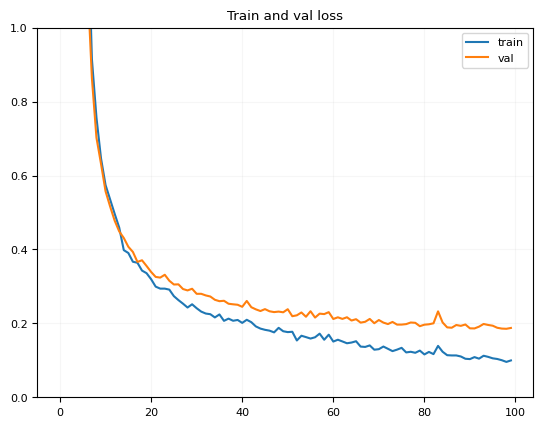

In [31]:
x_train = range(len(loss))
x_val = range(len(loss_eval))

plt.plot(x_train, loss, label='train')
plt.plot(x_val, loss_eval, label='val')

plt.grid(alpha=0.1)
plt.legend()
plt.title('Train and val loss')

plt.ylim(0, 1)
plt.show()


In [32]:
# get size of the model
total_size = 0
for p in model.parameters():
    size = 1
    for s in p.size():
        size *= s
    total_size += size
total_size

89153

In [33]:
test_loader = torch_geometric.loader.DataLoader(test_data,
                                                 batch_size=256,
                                                 shuffle=False)

model.eval()

preds = []
targets = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        ys = batch.energy.squeeze().to(device)
        predictions = model(batch.to(device)).squeeze()
        targets.extend(ys)
        preds.extend(predictions)

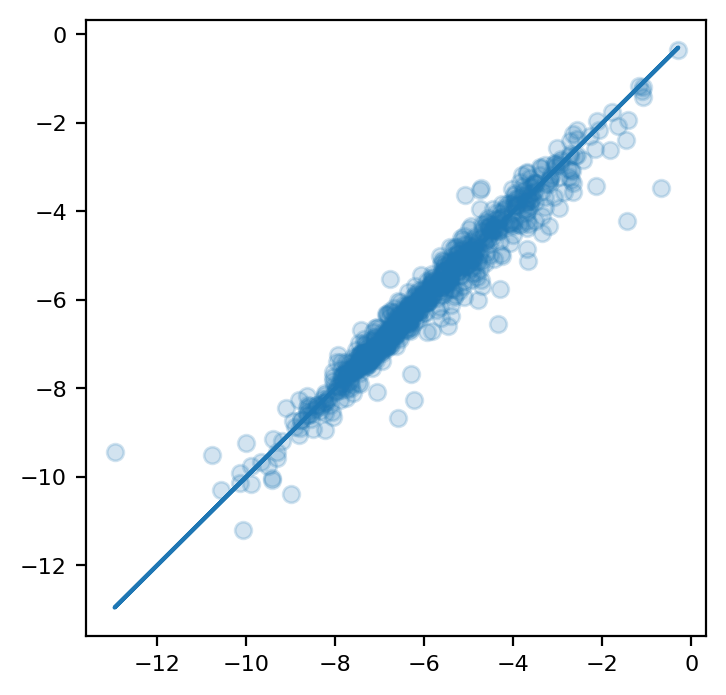

In [34]:
import matplotlib.pyplot as plt

plt.figure(dpi = 200, figsize = (4, 4))
plt.scatter(torch.tensor(targets).numpy(), torch.tensor(preds).numpy(), alpha = 0.2)
plt.plot(torch.tensor(targets).numpy(), torch.tensor(targets).numpy())

In [35]:
import numpy as np
from sklearn.metrics import r2_score

r2_score(torch.tensor(targets).numpy(), torch.tensor(preds).numpy())


0.9440768957138062

In [36]:
# RMSE, eV/atom
np.sqrt((abs(torch.tensor(targets).numpy() - torch.tensor(preds).numpy())**2).mean())

np.float32(0.38922206)

In [37]:
# MAE, eV/atom
abs(torch.tensor(targets).numpy() - torch.tensor(preds).numpy()).mean()

np.float32(0.2348379)